In [5]:
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap


In [18]:
flights = pd.read_excel('data/flight_data.xlsx', sheet_name='flights')
airports = pd.read_excel('data/flight_data.xlsx', sheet_name='airports')
airlines = pd.read_excel('data/flight_data.xlsx', sheet_name='airlines')
aircrafts = pd.read_excel('data/flight_data.xlsx', sheet_name='aircrafts')

In [25]:
(flights['destination'] == 'JFK').unique()

array([False])

In [26]:
(flights['destination'] == 'EWR').unique()

array([False])

In [27]:
(flights['destination'] == 'LGA').unique()

array([False,  True])

In [19]:
ny_nj_airports = ['EWR', 'JFK', 'LGA', 'SWF']
    
# Departure dataset
departures = flights[flights['origin'].isin(ny_nj_airports)].copy()

# Merge data
departures = departures.merge(airlines, on='airline_id', how='left')
departures = departures.merge(aircrafts, on='aircraft_id', how='left')
# Merge with origin airport data & rename
departures = departures.merge(airports, left_on='origin', right_on='airport_code', how='left')
departures = departures.rename(columns={'name': 'origin_airport_name', 
                                        'latitude': 'origin_lat',
                                        'longitude': 'origin_lon'})
# Merge again with destination airport data & rename
departures = departures.merge(airports, left_on='destination', right_on='airport_code', how='left')
departures = departures.rename(columns={'name': 'destination_airport_name', 
                                        'latitude': 'destination_lat',
                                        'longitude': 'destination_lon'})

In [22]:
arrivals = flights[flights['destination'].isin(ny_nj_airports)].copy()
arrivals

,airline_id,flight,origin,destination,aircraft_id,scheduled_departure,departure,departure_delay,scheduled_arrival,arrival,arrival_delay,air_time,distance
45253,OO,845,JFK,LGA,N312SY,2024-07-09 20:14:00,2024-07-10 08:59:00,765.0,2024-07-09 21:14:00,2024-07-10 09:49:00,755.0,19.0,17.70274


In [20]:
# Arrival dataset
arrivals = flights[flights['destination'].isin(ny_nj_airports)].copy()

# Merge data
arrivals = arrivals.merge(airlines, on='airline_id', how='left')
arrivals = arrivals.merge(aircrafts, on='aircraft_id', how='left')
# Merge with destination airport data & rename
arrivals = arrivals.merge(airports, left_on='destination', right_on='airport_code', how='left')
arrivals = arrivals.rename(columns={'name': 'destination_airport_name',
                                    'latitude': 'destination_lat',
                                    'longitude': 'destination_lon'})
# Merge again with origin airport data & rename
arrivals = arrivals.merge(airports, left_on='origin', right_on='airport_code', how='left')
arrivals = arrivals.rename(columns={'name': 'origin_airport_name',
                                    'latitude': 'origin_lat',
                                    'longitude': 'origin_lon'})

In [15]:
# Add time based features
for df in [departures, arrivals]:
        # Convert dates
        df['scheduled_departure'] = pd.to_datetime(df['scheduled_departure'])
        df['departure'] = pd.to_datetime(df['departure'])
        df['scheduled_arrival'] = pd.to_datetime(df['scheduled_arrival'])
        df['arrival'] = pd.to_datetime(df['arrival'])

        # Add time-based features
        df['month_dep'] = df['scheduled_departure'].dt.month
        df['month_name_dep'] = df['scheduled_departure'].dt.strftime('%B')
        df['day_of_week_dep'] = df['scheduled_departure'].dt.day_name()
        df['hour_dep'] = df['scheduled_departure'].dt.hour
        df['date_dep'] = df['scheduled_departure'].dt.date
        
        df['month_arr'] = df['scheduled_arrival'].dt.month
        df['month_name_arr'] = df['scheduled_arrival'].dt.strftime('%B')
        df['day_of_week_arr'] = df['scheduled_arrival'].dt.day_name()
        df['hour_arr'] = df['scheduled_arrival'].dt.hour
        df['date_arr'] = df['scheduled_arrival'].dt.date
        
        # Add delay categories for departures
        df['departure_delay_category'] = pd.cut(
            df['departure_delay'], 
            bins=[-np.inf, 0, 15, 60, np.inf],
            labels=['On Time/Early', 'Minor (1-15 min)', 'Moderate (16-60 min)', 'Major (>60 min)']
        )
        
        # Add delay categories for arrivals
        df['arrival_delay_category'] = pd.cut(
            df['arrival_delay'], 
            bins=[-np.inf, 0, 15, 60, np.inf],
            labels=['On Time/Early', 'Minor (1-15 min)', 'Moderate (16-60 min)', 'Major (>60 min)']
        )
        
        # Add boolean flags
        df['departure_is_delayed'] = df['departure_delay'] > 0
        df['departure_on_time'] = df['departure_delay'] <= 0
        df['arrival_is_delayed'] = df['arrival_delay'] > 0
        df['arrival_on_time'] = df['arrival_delay'] <= 0

In [6]:
departures['origin'].unique()

array(['EWR', 'JFK', 'LGA', 'SWF'], dtype=object)

In [8]:
departures.columns

Index(['airline_id', 'flight', 'origin', 'destination', 'aircraft_id',
       'scheduled_departure', 'departure', 'departure_delay',
       'scheduled_arrival', 'arrival', 'arrival_delay', 'air_time', 'distance',
       'airline', 'airport_code', 'origin_airport_name', 'origin_lat',
       'origin_lon', 'manufacturer', 'model', 'year', 'engines', 'seats',
       'max_weight_pounds'],
      dtype='object')

In [21]:
arrivals['origin'].unique()

array(['JFK'], dtype=object)

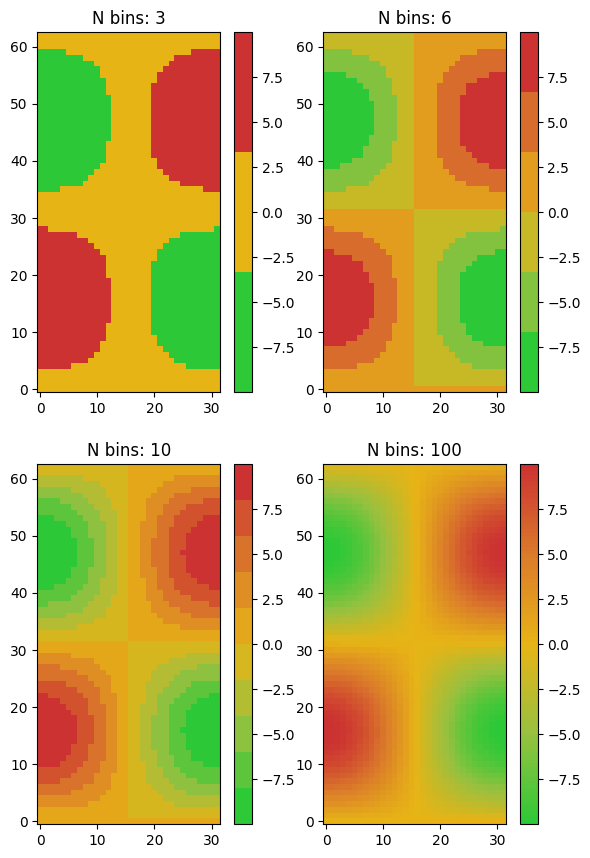

In [13]:
# Make some illustrative fake data:

x = np.arange(0, np.pi, 0.1)
y = np.arange(0, 2 * np.pi, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.cos(X) * np.sin(Y) * 10

colors = [(45,201,55),(153,193,64),(231,180,22),(219,123,43),(204,50,50)]  # R -> G -> B
colors = [tuple([round(c/255,4) for c in x]) for x in colors]
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_list'
fig, axs = plt.subplots(2, 2, figsize=(6, 9))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
for n_bin, ax in zip(n_bins, axs.flat):
    # Create the colormap
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, origin='lower', cmap=cmap)
    ax.set_title("N bins: %s" % n_bin)
    fig.colorbar(im, ax=ax)

In [ ]:
colors = [(45,201,55),(153,193,64),(231,180,22),(219,123,43),(204,50,50)]
colors = [tuple([round(c/255,4) for c in x]) for x in colors]
cmap_name = 'die_ampel'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

In [ ]:
a = pd.Series([1,34,6,7,8,32,4,6,23,5])
a


0     1
1    34
2     6
3     7
4     8
5    32
6     4
7     6
8    23
9     5
dtype: int64